In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import statsmodels as st
import statsmodels.api as sm
from scipy import stats
from pandas import DataFrame
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from dateutil.parser import parse
import scipy.stats as scs
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

#Stop warnings
import warnings
warnings.filterwarnings("ignore")

#### Read Data

In [2]:
def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d').dt.date
    
    return dat
# 10 hours of non zeroes 
def adherence_check1(df):
  df1 = df.copy()
  df1['Not Zero'] = df1['Steps'] > 0
  df1 = df1.groupby('Date').sum()
  df1 = df1['Not Zero'] > 10 
  return df1

#Greater than 500 steps
def adherence_check2(df,min):
  df1 = df.copy()
  df1 = df1.groupby('Date').sum()
  df1 = df1['Steps']> min
  return df1 

#Active in 3 time blocks 
def adherence_check3(df):
  df1 = df.copy()
  bins = [-1,2,10,14,25,np.inf]
  names = ['3','1','2', '3', '3']
  df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names, ordered=False)
  df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
  df1['Steps within timeblock'] = df1['Steps']> 0 
  df1 = df1.groupby('Date').sum()
  df1 = df1['Steps within timeblock'] ==3 
  return df1

#Combining it all into 1 dataframe
def three_method_table(x):
  valid_1= adherence_check1(x)
  valid_2= adherence_check2(x,500)
  #valid_3= adherence_check3(x)
  #result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
  result = pd.concat([valid_1,valid_2], axis=1, join='inner')
  result.reset_index(level=0, inplace=True)
  #result.columns = ["Date", "10 Hours Non Zero","Steps > 500","3 Timeblock"]
  result.columns = ["Date", "10 Hours Non Zero","Steps > 500"]
  #result['All 3 True'] = result["3 Timeblock"]*result["10 Hours Non Zero"]*result["Steps > 500"]
  result['All 3 True'] = result["10 Hours Non Zero"]*result["Steps > 500"]
  result_sum = result.sum()
  return result , result_sum

def filter_by_adherence(df, measure):
    df2 = three_method_table(df)[0]
    df3 = df.merge(df2,on ='Date')
    if(measure == 1):
        mask = (df3['10 Hours Non Zero'] == True)
    elif(measure == 2):
        mask = (df3['Steps > 500'] == True)
    elif(measure == 3):
        mask = (df3['All 3 True'] == True)
    filtered_df = df3.loc[mask].drop(['10 Hours Non Zero', 'Steps > 500', 'All 3 True'], axis=1)
    #filtered_df = filtered_df.drop('index', axis=1)
    return filtered_df

# Method 1 calculates daily steps based on all the step acitivity that is available during the day
def run_method_1(df):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 2 calculates daily steps based on the 10 most active hours of the day
def run_method_2(df):
    
    df = df.sort_values(by=["Date", "Steps"], ascending=False).groupby('Date').head(10)
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 3 calculates daily steps based on a 10 hour time block during the day
def run_method_3(df, start_hour, end_hour):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    mask = (df['Hour'] >= start_hour) & (df['Hour'] <= end_hour)
    df = df.loc[mask]
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

def calculate_daily_steps(file_name, filter_measure, start_time, end_time):
    
    df = read_CLEAN_data(filename)
    filtered_df = filter_by_adherence(df, filter_measure)
    
    dailysteps_method2 = run_method_2(filtered_df)
    dailysteps_method1 = run_method_1(filtered_df)
    dailysteps_method3 = run_method_3(filtered_df, start_time, end_time)
    
   
    return dailysteps_method1,dailysteps_method2,dailysteps_method3

In [3]:
filename = "user2.csv"

filter_measure = 2
start_time = 8
end_time = 18

ds_method1, ds_method2, ds_method3 = calculate_daily_steps(filename, filter_measure, start_time, end_time)

#### Method 1

In [4]:
ds_method1.set_index('Date',inplace=True)
ds_method1.shape

(1762, 1)

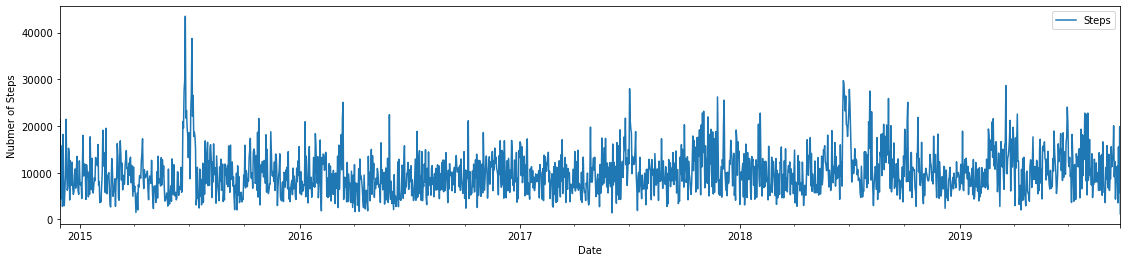

In [5]:
ds_method1.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

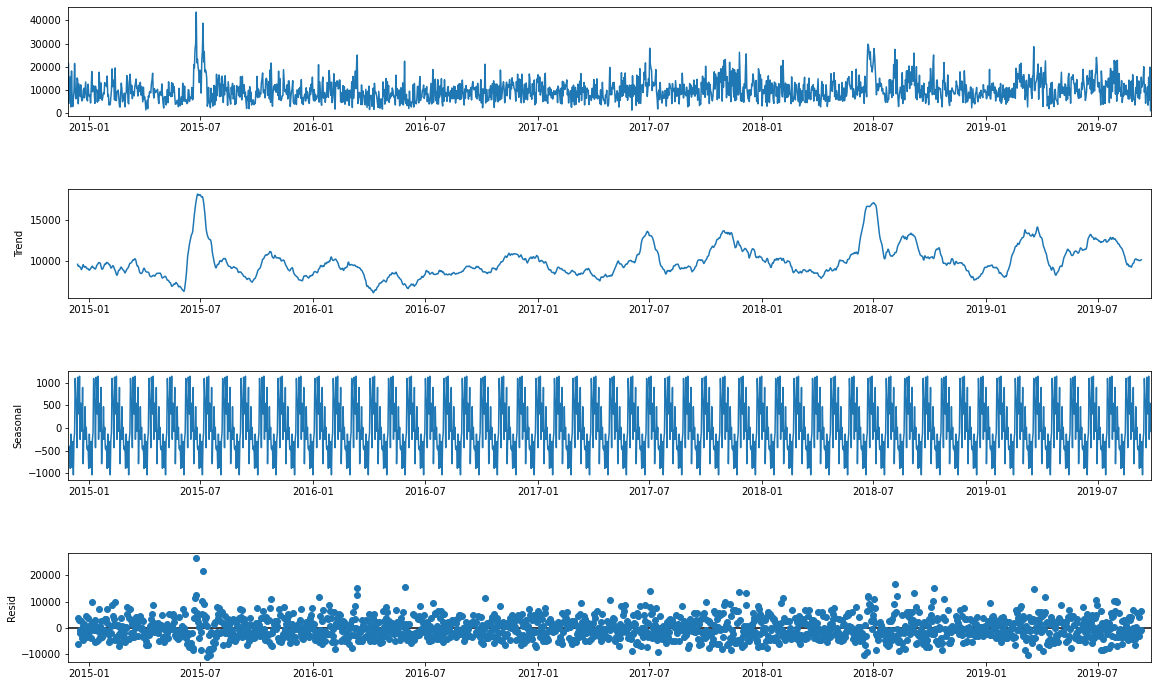

In [6]:
decomposition = sm.tsa.seasonal_decompose(ds_method1, model='additive', freq = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

The data still has seasonality 

#### Check for data stationary

In [7]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Number of Steps")
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Steps'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

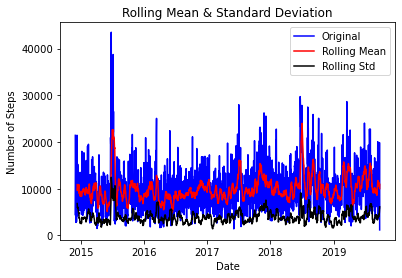

Results of Dickey Fuller Test:
ADF Test Statistic            -7.351087e+00
p-value                        1.005572e-10
#Lags Used                     2.000000e+01
Number of Observations Used    1.741000e+03
Critical Value (1%)           -3.434112e+00
Critical Value (5%)           -2.863202e+00
Critical Value (10%)          -2.567655e+00
dtype: float64


In [8]:
test_stationarity(ds_method1)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 1.005572e-10 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.

#### (S)ARIMA Parameters

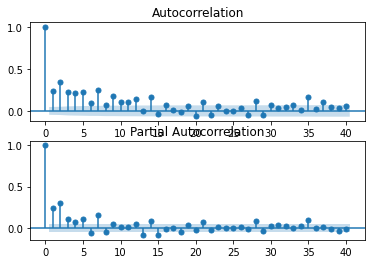

In [9]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method1, ax=ax[0], lags = 40)
fig = sm.graphics.tsa.plot_pacf(ds_method1, ax=ax[1], lags = 40)
plt.show()

In [10]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method1, start_p=0, start_q=0,
                           max_p=5, max_q=1, m=12,
                            seasonal=True,
                           d=0 , trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=34816.704, BIC=34838.601, Fit time=1.093 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=34850.751, BIC=34861.700, Fit time=0.039 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=34733.210, BIC=34755.107, Fit time=0.693 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=34757.322, BIC=34779.218, Fit time=0.307 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=34751.970, BIC=34768.393, Fit time=0.062 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=34726.922, BIC=34754.293, Fit time=2.148 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=34724.432, BIC=34757.277, Fit time=4.200 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=34818.625, BIC=34845.996, Fit time=4.224 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=34579.158, BIC=34617.477, Fit time=5.185 seconds
Fit ARIMA:

So, the best set of parameters to select is ARIMA(2,0,1)(2,0,1,12). I selected m = 12 to represent the yearly number of months each 'season' runs for

Optimization terminated successfully.
         Current function value: 9.818872
         Iterations: 5
         Function evaluations: 419


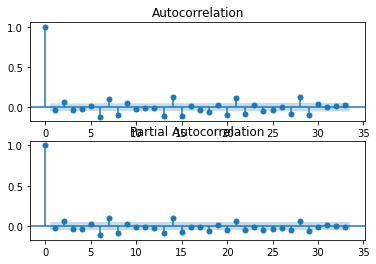

In [11]:
model = sm.tsa.statespace.SARIMAX(ds_method1, order=(2,0,1), seasonal_order = (2,0,1,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

In [12]:
train = ds_method1.loc['2014-11-29':'2018-10-08']
test = ds_method1.loc['2019-09-25':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 0, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [13]:
mod = sm.tsa.statespace.SARIMAX(ds_method1,
                                order=(2, 0, 1),
                                seasonal_order=(2, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Steps   No. Observations:                 1762
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 12)   Log Likelihood              -17042.268
Date:                            Wed, 18 Nov 2020   AIC                          34098.535
Time:                                    04:40:34   BIC                          34136.751
Sample:                                11-29-2014   HQIC                         34112.668
                                     - 09-25-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9321      0.032     29.507      0.000       0.870       0.994
ar.L2          0.0638      0.031   

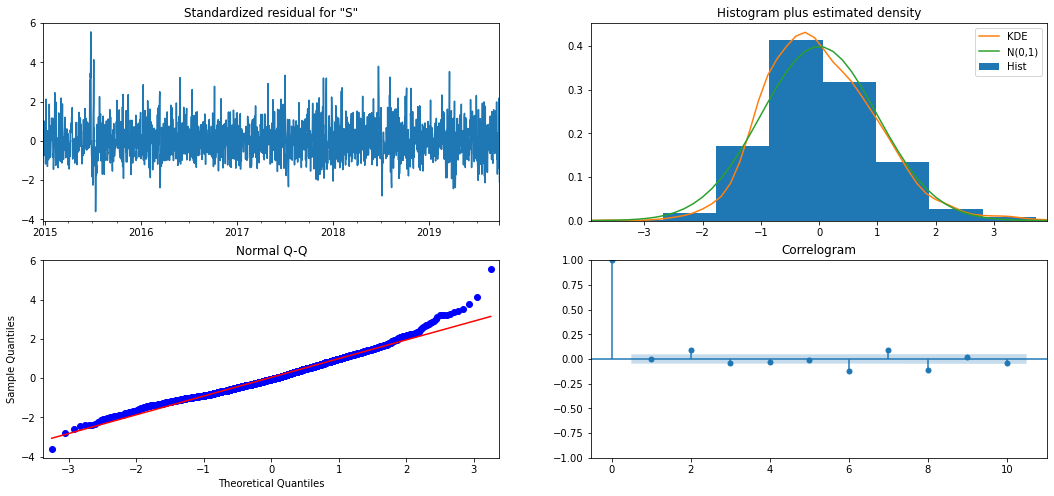

In [14]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

#### (S)ARIMA Model Validation

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [16]:
# the 20% point test data is on the specified date below
split_date = '2018-10-08'
data = ds_method1['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 0, 1),
                                seasonal_order=(2, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [17]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae1 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse1 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse1 = math.sqrt(mse1)
print(f'Mean Squared Error: {mse1.round(4)}')
print(f'Root Mean Squared Error: {round(rmse1,4)}')
print(f'Mean Absolute Error: {mae1.round(4)}')

Mean Squared Error: 44737514.678
Root Mean Squared Error: 6688.6108
Mean Absolute Error: 5311.7367


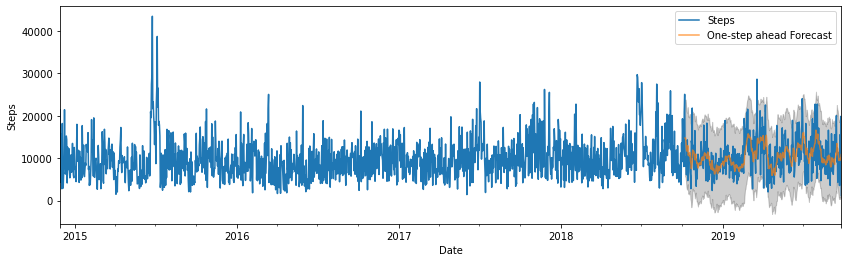

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-08'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method1['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

#### Method 2

In [19]:
ds_method2.set_index('Date',inplace=True)
ds_method2.shape

(1762, 1)

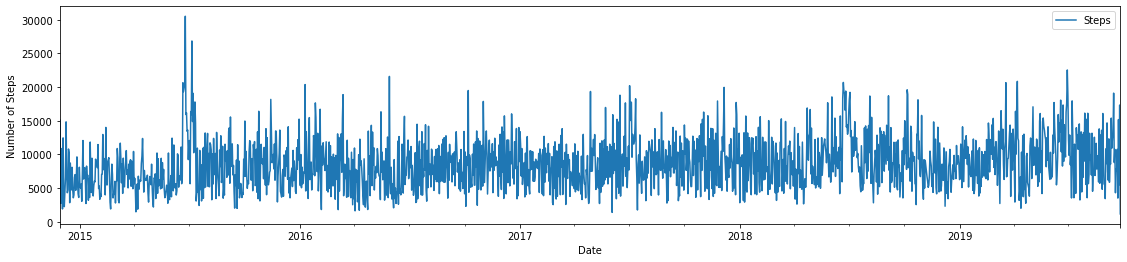

In [20]:
ds_method2.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

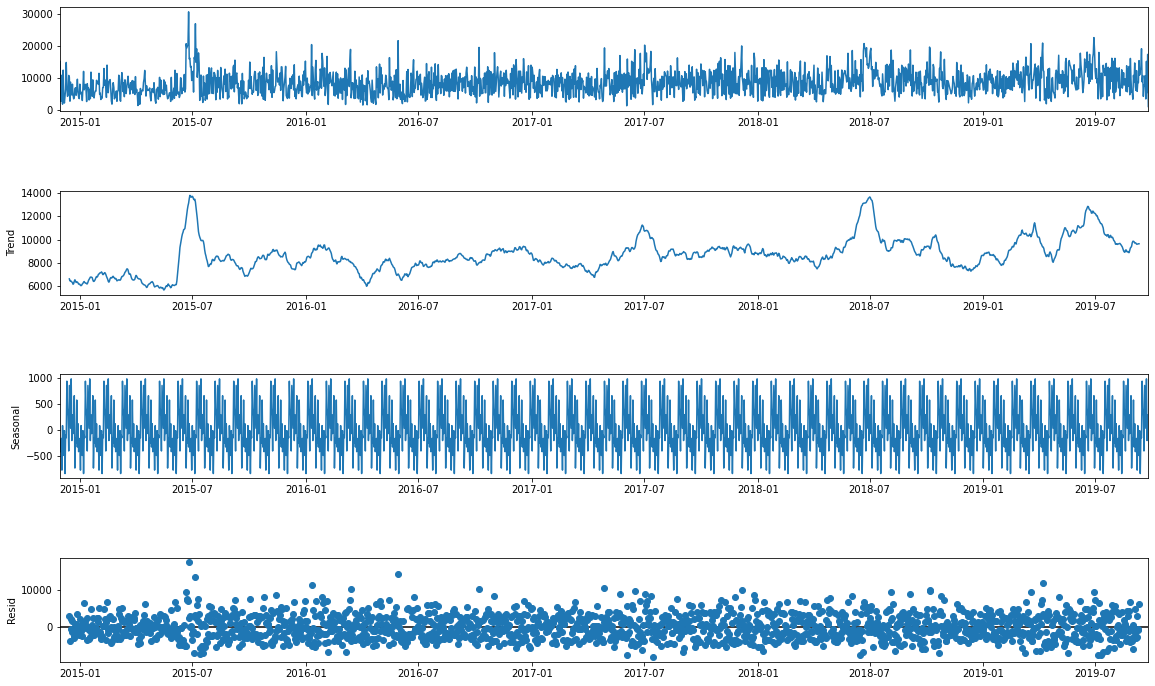

In [21]:
decomposition = sm.tsa.seasonal_decompose(ds_method2, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

Again, data is seasonable

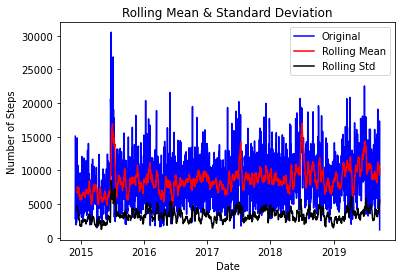

Results of Dickey Fuller Test:
ADF Test Statistic            -6.092922e+00
p-value                        1.026177e-07
#Lags Used                     2.000000e+01
Number of Observations Used    1.741000e+03
Critical Value (1%)           -3.434112e+00
Critical Value (5%)           -2.863202e+00
Critical Value (10%)          -2.567655e+00
dtype: float64


In [22]:
test_stationarity(ds_method2)

Data appears to be stationary

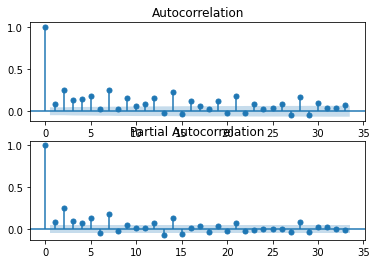

In [23]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method2, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method2,ax=ax[1])
plt.show()

In [24]:
stepwise_model = auto_arima(ds_method2, start_p=0, start_q=0,
                           max_p=3, max_q=5, m=12,
                            seasonal=True,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=35358.701, BIC=35380.597, Fit time=3.082 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=34069.422, BIC=34080.371, Fit time=0.026 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=34037.693, BIC=34059.590, Fit time=0.700 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=34025.762, BIC=34047.659, Fit time=0.285 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=34027.671, BIC=34055.042, Fit time=1.331 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=34062.807, BIC=34079.229, Fit time=0.105 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=34026.397, BIC=34053.768, Fit time=0.939 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=34028.254, BIC=34061.099, Fit time=4.357 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=34003.924, BIC=34031.295, Fit time=0.478 seconds
Fit ARIMA:

Best SARIMA is  order=(2, 0, 5) seasonal_order=(1, 0, 1, 12)

Optimization terminated successfully.
         Current function value: 9.618065
         Iterations: 5
         Function evaluations: 570


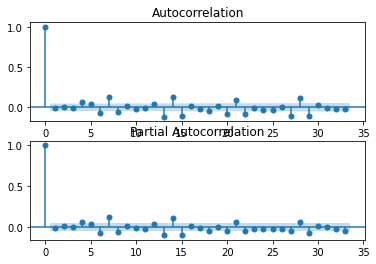

In [25]:
model = sm.tsa.statespace.SARIMAX(ds_method2, order=(2,0,5), seasonal_order = (1,0,1,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res,  ax=ax[1])
plt.show()

In [26]:
ds_method2.shape

(1762, 1)

In [27]:
train = ds_method2.loc['2014-11-29':'2018-10-08']
test = ds_method2.loc['2019-09-25':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 0, 5),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [28]:
mod = sm.tsa.statespace.SARIMAX(ds_method2,
                                order=(2,0,5),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Steps   No. Observations:                 1762
Model:             SARIMAX(2, 0, 5)x(1, 0, [1], 12)   Log Likelihood              -16763.708
Date:                              Wed, 18 Nov 2020   AIC                          33547.416
Time:                                      04:44:09   BIC                          33602.056
Sample:                                  11-29-2014   HQIC                         33567.618
                                       - 09-25-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2151      0.154      1.399      0.162      -0.086       0.516
ar.L2          0.78

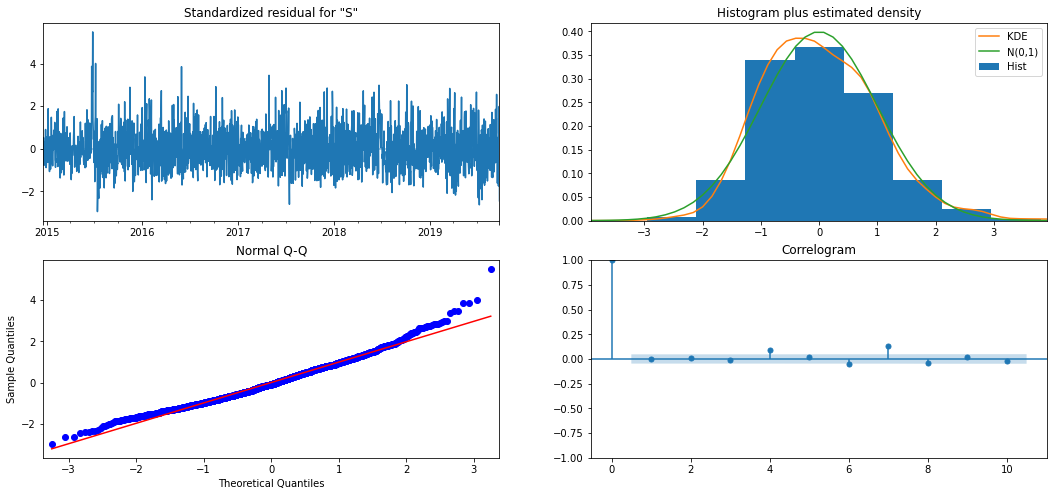

In [29]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [30]:
# the 20% point test data is on the specified date below
split_date = '2018-10-08'
data = ds_method2['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(2,0,5),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [31]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae2 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse2 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse2 = math.sqrt(mse2)
print(f'Mean Squared Error: {mse2.round(4)}')
print(f'Root Mean Squared Error: {round(rmse2,4)}')
print(f'Mean Absolute Error: {mae2.round(4)}')

Mean Squared Error: 15315571.2249
Root Mean Squared Error: 3913.5114
Mean Absolute Error: 3238.2266


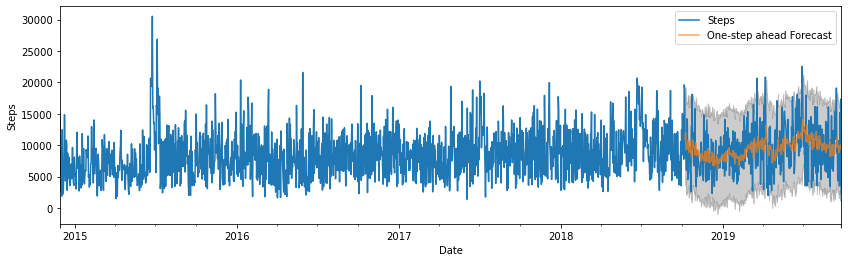

In [32]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-08'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method2['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

#### Method 3

In [33]:
ds_method3.set_index('Date',inplace=True)
ds_method3.head()

,Steps
Date,
2014-11-29,7088.666667
2014-11-30,2678.809798
2014-12-01,6489.632319
2014-12-02,11154.540779
2014-12-03,1646.644592


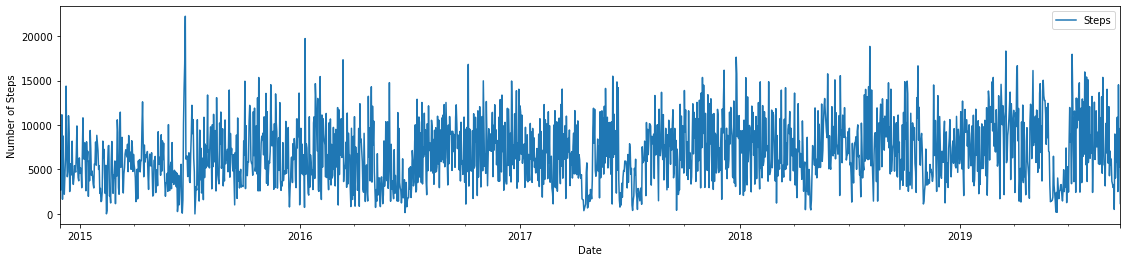

In [34]:
ds_method3.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

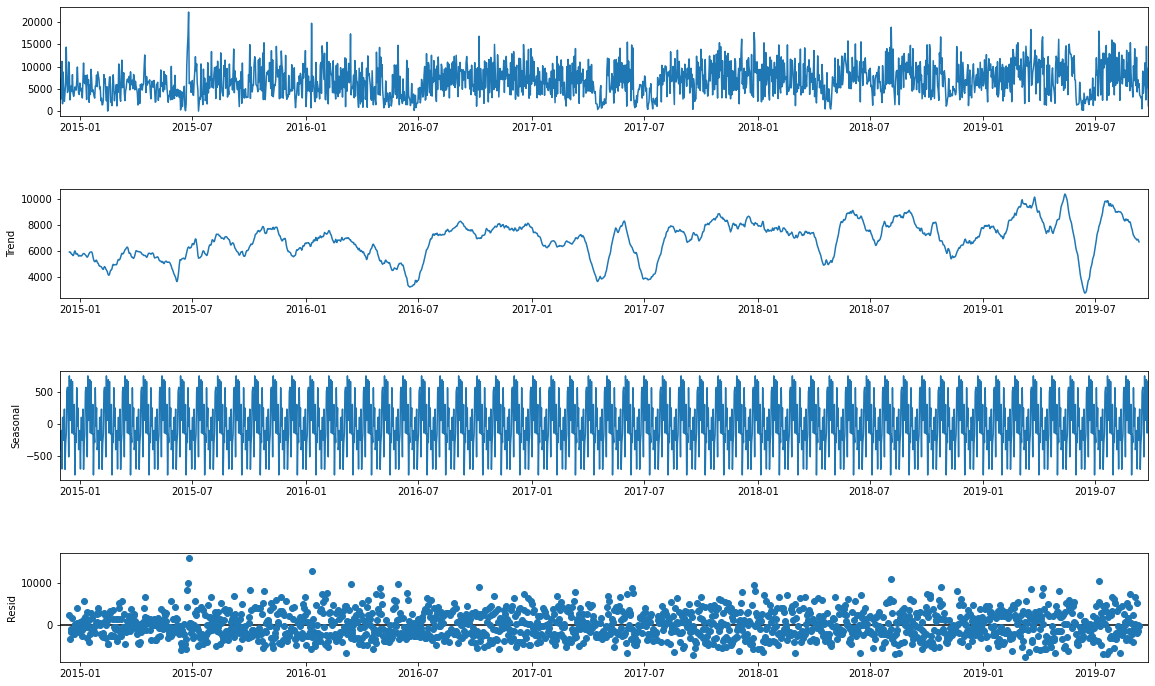

In [35]:
decomposition = sm.tsa.seasonal_decompose(ds_method3, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

Again, our data is seasonal

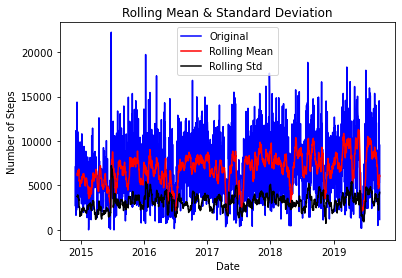

Results of Dickey Fuller Test:
ADF Test Statistic            -6.124350e+00
p-value                        8.701530e-08
#Lags Used                     2.000000e+01
Number of Observations Used    1.741000e+03
Critical Value (1%)           -3.434112e+00
Critical Value (5%)           -2.863202e+00
Critical Value (10%)          -2.567655e+00
dtype: float64


In [36]:
test_stationarity(ds_method3)

P-value is significant, our data is stationary

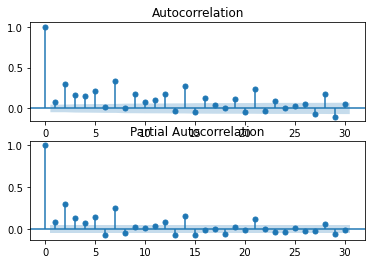

In [37]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method3, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method3, lags=30, ax=ax[1])
plt.show()

In [38]:
stepwise_model = auto_arima(ds_method3, start_p=0, start_q=0,
                           max_p=6, max_q=3, m=12,
                            seasonal=True,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=34167.909, BIC=34189.806, Fit time=2.387 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=33849.010, BIC=33859.958, Fit time=0.031 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=33810.896, BIC=33832.792, Fit time=0.952 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=33791.427, BIC=33813.324, Fit time=0.501 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=33793.175, BIC=33820.546, Fit time=1.392 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=33844.493, BIC=33860.915, Fit time=0.140 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=33792.229, BIC=33819.600, Fit time=1.030 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=33793.806, BIC=33826.651, Fit time=4.250 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=33764.748, BIC=33792.119, Fit time=0.558 seconds
Fit ARIMA:

Best ARIMA order=(4, 0, 3) seasonal_order=(0, 0, 0, 12)

Optimization terminated successfully.
         Current function value: 9.541443
         Iterations: 5
         Function evaluations: 475


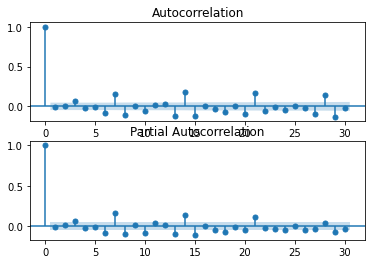

In [39]:
model = sm.tsa.statespace.SARIMAX(ds_method3, order=(4,0,3), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [40]:
train = ds_method3.loc['2014-11-29':'2018-10-08']
test = ds_method3.loc['2019-09-25':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(4, 0, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [41]:
mod = sm.tsa.statespace.SARIMAX(ds_method3,
                                order=(4,0,3),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                 1762
Model:               SARIMAX(4, 0, 3)   Log Likelihood              -16773.376
Date:                Wed, 18 Nov 2020   AIC                          33562.751
Time:                        04:45:52   BIC                          33606.527
Sample:                    11-29-2014   HQIC                         33578.930
                         - 09-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0655      0.128     -0.510      0.610      -0.317       0.186
ar.L2          1.1136      0.031     35.809      0.000       1.053       1.175
ar.L3          0.1396      0.124      1.127      0.2

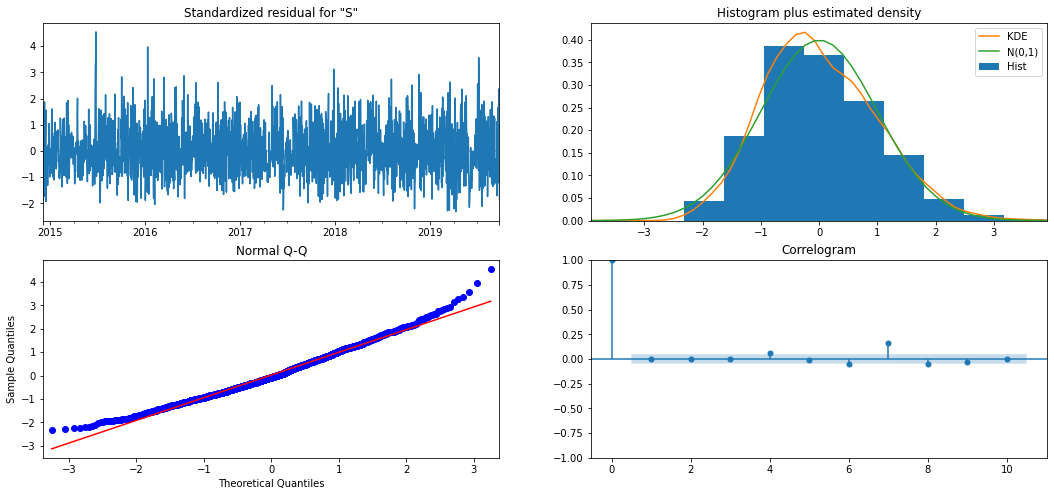

In [42]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [43]:
# the 20% point test data is on the specified date below
split_date = '2018-10-08'
data = ds_method3['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(4,0,3),
                                seasonal_order=(0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [44]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae3 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse3 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse3 = math.sqrt(mse3)
print(f'Mean Squared Error: {mse3.round(4)}')
print(f'Root Mean Squared Error: {round(rmse3,4)}')
print(f'Mean Absolute Error: {mae3.round(4)}')

Mean Squared Error: 15845450.1711
Root Mean Squared Error: 3980.6344
Mean Absolute Error: 3389.4868


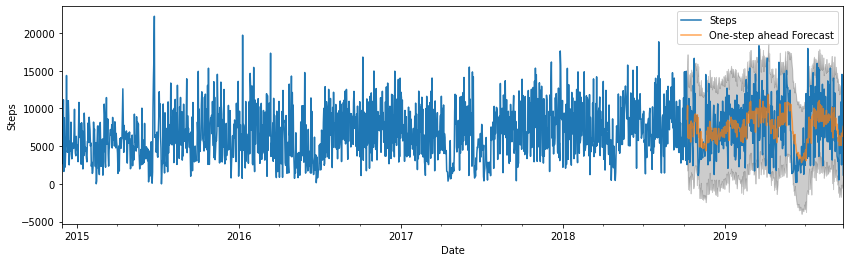

In [45]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-08'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method3['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

In [46]:
models = pd.DataFrame({
    'Method': ['Method 1', 'Method 2', 'Method 3'],
    'MSE': [round(mse1, 4), round(mse2, 4), round(mse3,4)],
    'RMSE': [round(rmse1,4 ), round(rmse2, 4), round(rmse3,4)],
    'MAE': [round(mae1, 4), round(mae2, 4), round(mae3,4)]})
models

,Method,MSE,RMSE,MAE
0,Method 1,4.473751e+07,6688.6108,5311.7367
1,Method 2,1.531557e+07,3913.5114,3238.2266
2,Method 3,1.584545e+07,3980.6344,3389.4868


Based on the above predictions, we can observe that **Method 2** and **Method 3** have a very similar prediction with **Method 1** performing the worst. However, the **RMSE** value of **Model 2** is lower, therefore, we can conclude that the **Method 2** performs the best here.